# Social Crop Challenge Notebook
    

In this notebook will be explain an step by step data flow to understand all the project developed


### Which Libraries I use?

In [1]:
%matplotlib inline
import matplotlib

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import os,sys

sys.path.append('../Factory')# commodity folder 
from Commodity import Commodity# for commodity entity


os.chdir("../") #execute this command once
commodityManager=Commodity()## rely on the current path should be after chdir


## alert to run this block please stop kernel because some relative path call could cause exceptions

D:\Felipe\Tesis\Pasantia\SocialCrop


Pandas for data Manipulation,
Numpy for maths and vector operation,
and Matplotlib for plots


### This is the Data,  Monthly_data_cmo_step1.csv, and CMO_MSP_Mandi_step1.csv

I will skip the step 1 because it is about Commodity Id addition


In [2]:
RELATIVE_PATH="./data/Cleaned/"
FILE_NAME= RELATIVE_PATH+"Monthly_data_cmo_step1"
FILE_NAME_2= RELATIVE_PATH+"CMO_MSP_Mandi_step1"
FILE_FORMAT=".csv"

DF_Month= pd.read_csv("./%s%s"%(FILE_NAME,FILE_FORMAT))
DF_SupportPrice= pd.read_csv("./%s%s"%(FILE_NAME_2,FILE_FORMAT))

DF_Month has information about monthly price for groups (Commodities,APMC) while DF_SupportPrice has information about support price for some crops, this is for farmers security and avoid losses


In [3]:
DF_Month.head()

,APMC,Commodity,Year,Month,arrivals_in_qtl,min_price,max_price,modal_price,date,district_name,state_name,CommodityId
0,Ahmednagar,Bajri,2015,April,79,1406,1538,1463,2015-04,Ahmadnagar,Maharashtra,1
1,Ahmednagar,Bajri,2016,April,106,1788,1925,1875,2016-04,Ahmadnagar,Maharashtra,1
2,Ahmednagar,Wheat(Husked),2015,April,1253,1572,1890,1731,2015-04,Ahmadnagar,Maharashtra,2
3,Ahmednagar,Wheat(Husked),2016,April,387,1750,2220,1999,2016-04,Ahmadnagar,Maharashtra,2
4,Ahmednagar,Sorgum(Jawar),2015,April,3825,1600,2200,1900,2015-04,Ahmadnagar,Maharashtra,3


In [4]:
DF_SupportPrice.head()

,commodity,year,Type,msprice,msp_filter,CommodityId
0,PADDY-UNHUSKED,2012,Kharif Crops,1250.0,1,38
1,RICE(PADDY-HUS),2012,Kharif Crops,1280.0,1,71
2,Jowar_Hybrid,2012,Kharif Crops,1500.0,1,203
3,SORGUM(JAWAR),2012,Kharif Crops,1520.0,1,3
4,BAJRI,2012,Kharif Crops,1175.0,1,1


Notice the commodityId in both Dataframes

### Date type, Remove Missing Prices, Remove Duplicates

In [5]:
print(len(DF_Month))
DF_Month["date"]=DF_Month["Year"].astype(str) +"-"+ DF_Month["Month"].astype(str)
DF_Month["date"]=pd.to_datetime(DF_Month["date"], format='%Y-%B')

DF_Month=DF_Month[DF_Month["min_price"]>0]
DF_Month=DF_Month[DF_Month["max_price"]>0]
DF_Month=DF_Month[DF_Month["modal_price"]>0]

#remove duplicates added
DF_Month=DF_Month.drop_duplicates(subset=["date","CommodityId","APMC"], keep='first')

print(len(DF_Month))

62429
62171


### I defined a function to remove  some groups that didn't have enough information less than one year of records


In [6]:
def removeTsFewRecords(MyDataFrame):
    MyDataFrameInt=MyDataFrame.copy()
    DF_Count= MyDataFrameInt.groupby(["CommodityId","APMC"])["CommodityId"].count()
    count_before=len(DF_Count)
    ## filter the commodities-APMC which don't have at least 3 year of information
    filterCriterian=12
    DF_Count=DF_Count[DF_Count>=filterCriterian ]
    count_after=len(DF_Count)
    #DF_Count.plot.box()
    
    DF_Count=DF_Count.to_frame()
    DF_Count.columns=["Count"]
    DF_Count.reset_index(inplace=True)
    diff=count_before-count_after
    print("Clusters eliminated: "+ str(diff))
    MyDataFrameInt=MyDataFrameInt.merge(DF_Count, how="inner")
    
    return MyDataFrameInt[["date","APMC", "CommodityId", "min_price","max_price","modal_price","arrivals_in_qtl" ]]
    

In [7]:
## Apply the function 
print(len(DF_Month))
DF_Month=removeTsFewRecords(DF_Month)
print(len(DF_Month))

62171
Clusters eliminated: 2447
50940


I defined another function call removeOutliers.py that can be seen in file OutliersDetection.py
this remove records based on the formula of normal distribution mean +- 2std
the output of this is the file Monthly_data_cmo_step2

In [8]:
FILE_NAME=RELATIVE_PATH+"Monthly_data_cmo_step2"
DF_Month= pd.read_csv("./%s%s"%(FILE_NAME,FILE_FORMAT))
print(len(DF_Month))

45152


### Now I will show how the groups behave in comparison  of the Commodity
for all the commodities you can see file PlotByCommodity.py and the Report CommoditiesTS_modal_price.pdf

In [9]:
## this for manage commodity entity
%matplotlib inline

def viewPlotsTS(DataFrame_View,myColumnValue):
    GrouperColumns=["CommodityId"]
    
    by_group = DataFrame_View.groupby(GrouperColumns)
    
    by_group=sorted(by_group,  # iterates pairs of (key, corresponding subDataFrame)
                key=lambda x: len(x[1]),  # sort by number of rows (len of subDataFrame)
                reverse=True)  # reverse the sort i.e. largest first
    
    
    for name, group in by_group:
        
        group=group.sort_values("date")
        
        
        fig, ax  = plt.subplots(figsize=(20, 8))
        
        realName= commodityManager.getNameById(name)
        plt.title(str(name)+"-"+realName+"-TS Plot")
        #for this comodity which is the APMC associated
        apmcs=group["APMC"].unique()[:15]
        
        for index,item in enumerate(apmcs):
            groupFiltered=group[group["APMC"]==item]
            groupFiltered["date"]=pd.to_datetime(groupFiltered["date"])
            groupFiltered=groupFiltered.set_index("date")
            groupFiltered=groupFiltered.sort_index()
            
            #print(groupFiltered)
            
            ts=groupFiltered[myColumnValue]
            ts.plot(label=item)   
            
        ax.legend(loc='best')
        plt.show()
        break # just one iteration
        

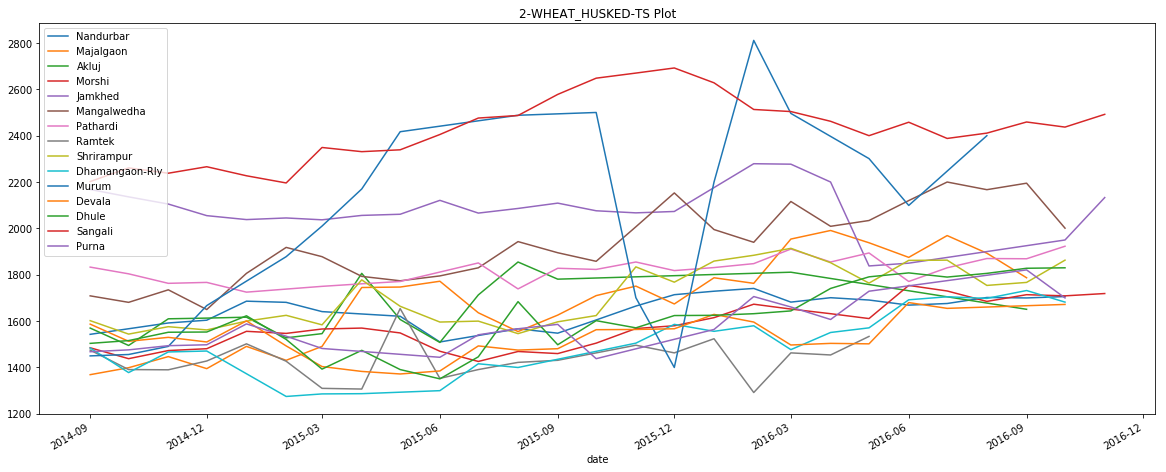

In [10]:
# Call the function
pd.options.mode.chained_assignment = None  # default='warn'
viewPlotsTS(DF_Month,"modal_price")

Using this plot is possible to see some general behavior in the data max and min values an peak

### Seasonal analysis and Trends
In the next plot is possible to analyse the seasonal component against some frequencies



In [11]:
from statsmodels.tsa.seasonal import seasonal_decompose

GrouperColumns=["CommodityId"]
def viewPlotsTSSeason(DataFrame_View):
    by_group = DataFrame_View.groupby(GrouperColumns)
    
    by_group=sorted(by_group,  # iterates pairs of (key, corresponding subDataFrame)
                key=lambda x: len(x[1]),  # sort by number of rows (len of subDataFrame)
                reverse=True)  # reverse the sort i.e. largest first
    
    for name, group in by_group:
        group=group.sort_values("date")
        realName= commodityManager.getNameById(name)
        displayName=str(name)+"-"+realName
        #plt.title(str(name)+"-"+realName+"-TS Plot")
        #for this comodity which is the APMC associated
        apmcs=group["APMC"].unique()[:1]
        
        for index,item in enumerate(apmcs):
            
            groupFiltered=group[group["APMC"]==item]
            groupFiltered=groupFiltered.sort_values("date")
            groupFiltered["date"]=pd.to_datetime(group["date"])
            groupFiltered=groupFiltered.set_index("date")
            groupFiltered=groupFiltered.sort_index()
            groupFiltered=groupFiltered[["modal_price"]]
            
            fig, ax  = plt.subplots(figsize=(20, 8))
            ax.set_title(realName)
            FREQ= [3,6,12]   
            for ite in range(3) :
                
                
                frequency=FREQ[ite]
                if(len(groupFiltered)<=frequency):
                    break
                result=seasonal_decompose(groupFiltered, model='additive', freq=frequency)
                result2=seasonal_decompose(groupFiltered,freq=frequency,model='multiplicative')
                
                ax1= plt.subplot(1, 3, ite+1)
                plt.plot(groupFiltered.index, groupFiltered['modal_price'], label="Original")
                plt.plot(groupFiltered.index, result.seasonal, label="Seasonal  Additive")
                plt.plot(groupFiltered.index, result2.seasonal, label="Seasonal  Multiplicative")
                ax1.set_title("%s Frequency: %s Months"%(displayName,frequency))
                ax1.legend(loc='best')
                plt.xticks(rotation=90)
        
            
        
        break



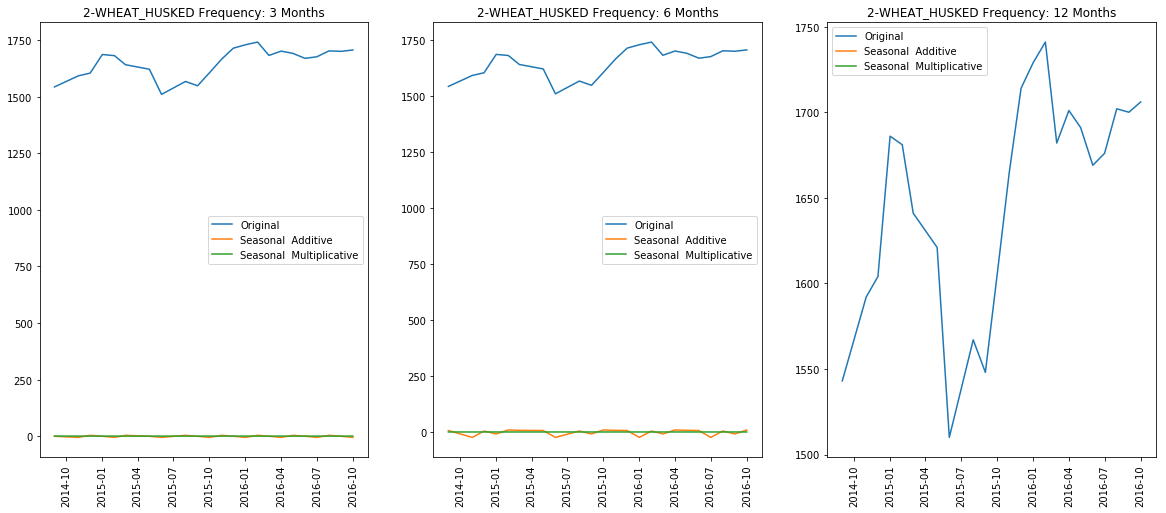

In [12]:
viewPlotsTSSeason(DF_Month)

This graphic was useful to see if the data was multiplicative model or additive, the complete report can be seen in the file PlotSeasonalityDetection.py, and the report could be reviewed in the file CommoditiesSeasonalAnalysis.pdf.

### What kind of model is correspond commodity data?
The answer is additive model because when tren change seasonality  stay equal

### What frequency is better for each commodity and model seasonality ?
The plot haven't shown enough information to answer this question however, in the complete report you can see that no all are annual or quarterly or biannual.


### Seasonal Inference
This script is to analyze the monthly data for each group of commodity-APMC

for each group the script will try to find the best seasonal behavior 
taking the Dickey Fullier Test and iterating over multiple frequencies [1,3,6,12]

The p value was defined as THRESHOLD_pvalue=0.3, to accept data with 30% because data is not so uniform
after run every test the script select the frequency that is better to deseasonalize the time series

Note that no all the data pass the test because some time is so difficult find patterns in the data



In [13]:
from statsmodels.tsa.stattools import adfuller
def testStationary(TimeSeries):
    #print("Result of Dickey Fullier Test")
    
    
    TimeSeries=TimeSeries.dropna()
    dftest=adfuller(TimeSeries, autolag="AIC")
    dfoutput= pd.Series(dftest[0:4], index=["Test Stat","P-Value","#Lags Used", "Number of Observarions"])
    
    for key,value in dftest[4].items():
        dfoutput["Critical Value: %s"%key]=value
    #print("P-value",dfoutput["P-Value"])
    
    return dfoutput["P-Value"]
    

This function is for validate if a time series is stationary or not, the less that we get of the p_vlaue the most stationary the timeseries will be

In [14]:
def SeasonalityColumnRemove(DataFrame_View):
    
    GrouperColumns=["CommodityId","APMC"]
    by_group = DataFrame_View.groupby(GrouperColumns)
    
    by_group=sorted(by_group,  # iterates pairs of (key, corresponding subDataFrame)
                key=lambda x: len(x[1]),  # sort by number of rows (len of subDataFrame)
                reverse=True)  # reverse the sort i.e. largest first
    i=0
    MAX_I=3
    dataset=None
    countUmbral=1
    countAllGroups=len(by_group)
    for name, group in by_group:
        
        group=group.sort_values("date")
        group["date"]=pd.to_datetime(group["date"])
        group=group.set_index("date")
        group=group.sort_index()
        
        #SELECTED 
        TYPE="additive"
        FREQ= [1,3,6,12]
        #frequency=FREQ
        ts_price=group["modal_price"]
        ts_price_log=np.log(group["modal_price"])
        
        ts_price_used=ts_price_log
        
        print("######## New Item %d %s #############"%(name))
        testStationary(ts_price)
        
        THRESHOLD_pvalue=0.3
        currentP=99
        currentFreq=99
        
        for frequency in FREQ:
            #print("*********This is for %d***************"%frequency)
            ts_price_freq_mean=ts_price_used.rolling(frequency).mean()
            ts_price_freq_std=ts_price_used.rolling(frequency).std()
            # remove seasonality and trend
            group["modal_price_nostationary_ma"]=ts_price_used- ts_price_freq_mean
            group['log_ret_monthly'] = np.log(group["modal_price"]) - np.log(group["modal_price"].shift(1))
            group['log_ret_frequency'] = np.log(group["modal_price"]) - np.log(group["modal_price"].shift(frequency))
            
            #group["modal_price_nostationary_diff"]=group["modal_price"]-  group["modal_price"].shift(1)- group["modal_price"].shift(frequency)
            
            localP=testStationary(group["modal_price_nostationary_ma"])
            #localP=testStationary(group["modal_price_nostationary_diff"])
            if(localP<currentP):
                currentP=localP
                currentFreq=frequency
                #Commodity Frequency Fluctuation
                group['rate_monthly_fluc']=np.mean(group['log_ret_monthly']**2)
                
                #Monthly Frequency Fluctuation
                group['rate_frequency_fluc']=np.mean(group['log_ret_frequency']**2)
            
        del group['log_ret_monthly']
        del group['log_ret_frequency'] 
        
        group["Frequenc_Seasonality"]= currentFreq   
        print("Best P Value::::::")
        print("P-value",currentP)
        print("Frequency",currentFreq)
        
        if(currentP > THRESHOLD_pvalue):
            countUmbral += 1
       
            group.reset_index(level=0, inplace=True)
            if dataset is None:
               dataset=group
            else: 
               dataset=dataset.append(group, ignore_index=True) 
        i=i+1
        if(i==MAX_I):
            break
    print("didn't pass the Test of Stationary::",countUmbral)
    print("Total Groups ::",countAllGroups)
    
    
    
    return dataset

In [15]:
SeasonalityColumnRemove(DF_Month)

######## New Item 1 Chopda #############
Best P Value::::::
P-value 0.0638174630814
Frequency 1
######## New Item 1 Manmad #############
Best P Value::::::
P-value 0.095618233517
Frequency 6
######## New Item 1 Nandurbar #############
Best P Value::::::
P-value 0.00872049183448
Frequency 3
didn't pass the Test of Stationary:: 1
Total Groups :: 2237


C:\Users\lfvargas\AppData\Local\Continuum\Anaconda3\envs\myEnvTesis\lib\site-packages\statsmodels\regression\linear_model.py:1510: RuntimeWarning: divide by zero encountered in double_scalars
  return np.dot(wresid, wresid) / self.df_resid


This function iterate over frequencies and use Moving average with each frequency value 
and select the one that minimize the p_vaue when the data didn't pass the test this group is not save

As you see in the output he selected frequencies of 1, 6 and 3 for each group this new column is storage in
step3 csv file

also two new columns are created: for monthly fluctuation and for seasonality(frequency) fluctuation 



In [16]:
## read step3 file
FILE_NAME=RELATIVE_PATH+"Monthly_data_cmo_step3"
DF_Month= pd.read_csv("./%s%s"%(FILE_NAME,FILE_FORMAT))
print(len(DF_Month))

8947


### Price Support Plot 

this plot is for showing the price support with the real time series and the stationary transformation

In [17]:

def SeasonalityPrice(DataFrame_View):
    GrouperColumns=["CommodityId","APMC"]
    by_group = DataFrame_View.groupby(GrouperColumns)
    
    by_group=sorted(by_group,  # iterates pairs of (key, corresponding subDataFrame)
                key=lambda x: len(x[1]),  # sort by number of rows (len of subDataFrame)
                reverse=True)  # reverse the sort i.e. largest first
    
    i=0
    MAX_I=1
    
    
    dataset=None
    
    DF_SupportPrice["date"]=pd.to_datetime(DF_SupportPrice["year"], format='%Y')

    
    for name, group in by_group:
        
        realName= commodityManager.getNameById(name[0])
        displayName=str(name[0])+"-"+realName
        displayName=displayName+"-"+name[1]
                       
        group=group.sort_values("date")
        
        group["date"]=pd.to_datetime(group["date"])
        group=group.set_index("date")
        group=group.sort_index()
        
        # get minimum support price by year 
        
        
        DF_LocalPrice=DF_SupportPrice[DF_SupportPrice["CommodityId"]==name[0]]
        
        if(len(DF_LocalPrice)==0):
            break
        
        DF_LocalPrice["date"]=pd.to_datetime(DF_LocalPrice["date"])
        DF_LocalPrice=DF_LocalPrice.set_index("date")
        DF_LocalPrice=DF_LocalPrice.sort_index()
        
        
        minDate=group.index.min()
        maxDate=group.index.max()
        
        DF_LocalPrice=DF_LocalPrice.loc[minDate:maxDate]
        
        
        
        supportPrice_TS=np.log(DF_LocalPrice["msprice"])
        
        
        #SELECTED 
        TYPE="additive"
        FREQ= 12
        frequency=group["Frequenc_Seasonality"].iloc[0]
        
        ts_price_log=np.log(group["modal_price"])
        
        
        ts_price_freq_mean=ts_price_log.rolling(frequency).mean()
        ts_price_freq_std=ts_price_log.rolling(frequency).std()
     
        
        
        group["modal_price_nostationary"]=ts_price_log - ts_price_freq_mean
        
        fig, ax  = plt.subplots(figsize=(8,15))
        ax.set_title(displayName)
        plt.plot(group.index,ts_price_log , label="Series")
        plt.plot(group.index,group["modal_price_nostationary"], label="No Season- No Trend Moving Average" ) 

        ts_price_freq_mean.plot(label="%s month rolling mean"%frequency)
        ts_price_freq_std.plot(label="%s month rolling std"%frequency)
        supportPrice_TS.plot(label="Minimum Support Price")
        #print(ts_price)
        #autocorrelation_plot(ts_price)
        
        ax.legend(loc='best')
        
        plt.xticks(rotation=90)
        group=group.reset_index(level=0)
        if dataset is None:
           dataset=group
        else: 
           dataset=dataset.append(group, ignore_index=True) 
        i=i+1
        
        if(i==MAX_I):
            break
    
    





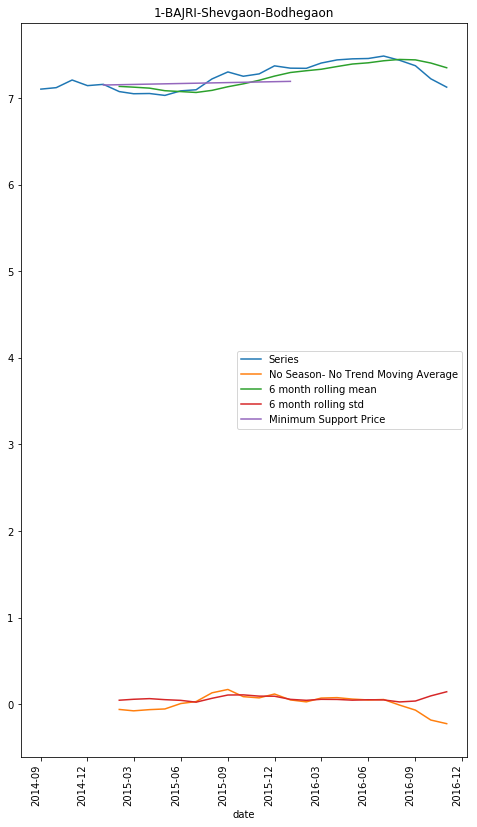

In [18]:
SeasonalityPrice(DF_Month)

The complete code could be find in the file PlotSeasonalDecomPriceSupport.py and can be seen in the report GroupsSupporPriceAnalysis.pdf


## Price Fluctuation 

This report shows the groups with high fluctuation

In [19]:


def flagMostFluctuation(DataFrame_View):
    by_group = DataFrame_View.groupby(["CommodityId"])
    
    dataset= None
    for name, group in by_group:
        rate_monthly_fluc=group["rate_monthly_fluc"]
        rate_frequency_fluc=group["rate_frequency_fluc"]
        
        LIMIT=.9
        limitMonth=rate_monthly_fluc.quantile(LIMIT)
        limitFreq=rate_frequency_fluc.quantile(LIMIT)

        
        def comparable(x,y):
            if(x>y):
                return True
            else:
                return False
        
        group["Highest_Fluctuation_Month"]=rate_monthly_fluc.apply(lambda x: comparable(x,limitMonth))
        group["Highest_Fluctuation_Freq"]=rate_frequency_fluc.apply(lambda x: comparable(x,limitFreq))
        
        if dataset is None:
            dataset=group
        else: 
            dataset=dataset.append(group, ignore_index=True) 
            
        
               
    return dataset

def viewFlagged(DataFrame_View):  
    GrouperColumns=["CommodityId","APMC"]
    by_group = DataFrame_View.groupby(GrouperColumns)
    
    by_group=sorted(by_group,  # iterates pairs of (key, corresponding subDataFrame)
                key=lambda x: len(x[1]),  # sort by number of rows (len of subDataFrame)
                reverse=True)  # reverse the sort i.e. largest first
    
    for name, group in by_group:
        
        isHighFreq=group["Highest_Fluctuation_Freq"].iloc[0]
        isHighMonth=group["Highest_Fluctuation_Month"].iloc[0]
        if(isHighFreq or isHighMonth):
            realName= commodityManager.getNameById(name[0])
            displayName=str(name[0])+"-"+realName
            displayName=displayName+"-"+name[1]
            
            fig, ax  = plt.subplots(figsize=(8,10))
            ax.set_title(displayName)
            
            group=group.sort_values("date")
            
            
            group["date"]=pd.to_datetime(group["date"])
            group=group.set_index("date")
            group=group.sort_index()
            
            plt.plot(group.index,group["modal_price"] , label="Series")
            
            
            ax.legend(loc='best')
            
            plt.xticks(rotation=90)
            
            break
            
            
            


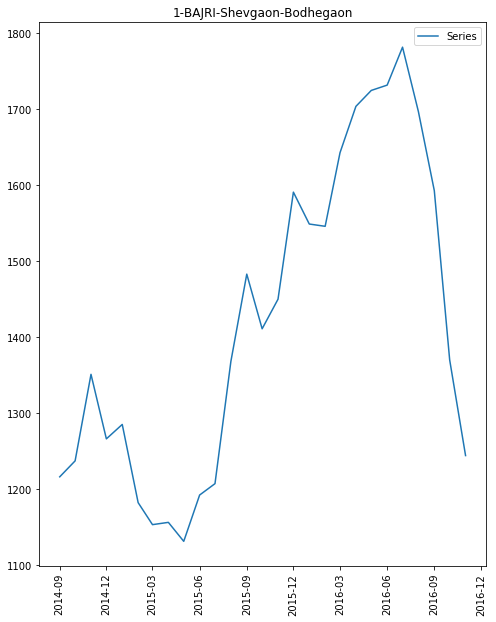

In [20]:
DF_flag=flagMostFluctuation(DF_Month)
viewFlagged(DF_flag)

This plot show one of them you can see the complete report in file GroupsHighFluctuation.pdf
and the complete code in file PlotHighestFluctuation.py



## Summary 

This notebook shows how to get data from commodities price remove trends and seasonality
try differents frequencies given the lack of knowledge about problem seasonality and identified the crops 
with more fluctuations